In [1]:
import multiprocessing as mp
import os
import random
import re
import sys
import warnings

sys.path.append('../tools/')

import backtest_cdb_large as bcl
import matplotlib.patches as mpathes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from backtest_cdb import *
from matplotlib import ticker
from numba import jit
from PqiData import *
from PqiDataSdk import PqiDataSdk
from tqdm import tqdm


warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = ['DejaVu Sans']

ds = PqiDataSdk(user="zyding", size=64, pool_type="mt", show_log=True)

In [171]:
class Config:
    # 用户名 - str
    user = 'zyding'
    # 票池 - 可以填list['000001', '000002'] / 指数代号'000852' / 自定义票池'xxx.csv'
    # 注意使用自定义票池的时候start_date和end_date要与配置里一致。
    # 自定义票池的数据形式为：index为ticker，column为date，值为1或nan的2d dataframe
    tickers = 'all'
    # 拉取数据的进程数，如果要使用接口批量测因子，这里要写为1，如果不填默认是12
    size = 1
    # 拉取数据最早日期，可以早于start_date
    earliest_date = '20170101'
    # 回测起止日期 - str
    start_date = '20180701'
    # start_date = '20210101'
    end_date = '20220731'
    # 全部参考指数 - 可以把想看的指数全部填在indexs的list中
    indexs = ['000852', '000905', '000300', '000906']
    # 看超额基准指数 - summary图中alpha_rtn的基准指数，如果填'mean'则benchmark为票池平均return，填指定指数则benchmark为指数收益
    benchmark_index = '000852'
    # 费率 - 换手手续费
    fee_rate = 0.0013
    # return的计算方式 - 'Open2Open' / 'Close2Close' / 'TwapOpen2TwapOpen' / 'TwapClose2TwapClose' 注意大小写以及中间的2
    # 选择 TwapOpen2TwapOpen / TwapClose2TwapClose 的 rtn_type 回测start_date不能早于20150101
    rtn_type = 'TwapOpen2TwapOpen'
    # 分组数
    group_num = 30
    # 正常回测写normal，如果有从文件中读dataframe的需求这里写“exist_df”
    mode = 'normal'
    # 添加按头组数目分多空分组，填'mean'则是按因子值均值分两组，填整数则为指定多空组票数，如果填一个小于1的浮点数则是按比例入选多空分组
    long_short_type = 400
    # long_short_type='0.9'
    # 多空组内持仓比例方式，'factor_value'-因子值加权；'equal'-组内等权
    weight_type = 'factor_value'


plot_config = {'fig_width': 15, 'fig_height': 15, 'sample_interval': 30}
cfg = Config()

In [3]:
# os.chdir('/home/zyding/low_fre_backtest_plot/')

In [4]:
# os.system('python main.py')

In [5]:
tickers = ds.get_ticker_list(date='all')
start_date = '20170101'
end_date = '20230131'
lst_trade_date = ds.get_trade_dates(start_date=start_date, end_date=end_date)
DTIndex_trade_date = pd.to_datetime(lst_trade_date).map(lambda x: x.date)

In [6]:
tickers_zz500 = ds.get_index_weight(ticker='000905').StockTicker.values
tickers_zz1000 = ds.get_index_weight(ticker='000852').StockTicker.values
tickers_hs300 = ds.get_index_weight(ticker='399300').StockTicker.values

tickers_zz1800 = np.concatenate([tickers_hs300, tickers_zz500, tickers_zz1000])

In [7]:
tickers_zz1000_eod = ds.get_index_weight(ticker='000852',
                                         start_date=start_date,
                                         end_date=end_date,
                                         format='eod')

tickers_zz500_eod = ds.get_index_weight(ticker='000905',
                                        start_date=start_date,
                                        end_date=end_date,
                                        format='eod')

tickers_hs300_eod = ds.get_index_weight(ticker='399300',
                                        start_date=start_date,
                                        end_date=end_date,
                                        format='eod')

tickers_zz800_eod = ds.get_index_weight(ticker='000906',
                                        start_date=start_date,
                                        end_date=end_date,
                                        format='eod')

tickers_all_eod = ds.get_index_weight(ticker='000985',
                                      start_date=start_date,
                                      end_date=end_date,
                                      format='eod')

tickers_zz1800_eod = (tickers_hs300_eod.replace(np.nan, 0) +
                      tickers_zz500_eod.replace(np.nan, 0) +
                      tickers_zz1000_eod.replace(np.nan, 0)).replace(0, np.nan)

In [8]:
tickers_up_feasible = ds.get_file(name='up_feasible',
                                  start_date=start_date,
                                  end_date=end_date,
                                  format='ticker_date_real')

tickers_down_feasible = ds.get_file(name='down_feasible',
                                    start_date=start_date,
                                    end_date=end_date,
                                    format='ticker_date_real')

In [9]:
eod_stock = ds.get_eod_history(fields=['OpenPrice', 'ClosePrice', 'TradeVolume'],
                               tickers=ds.get_ticker_list(date='all'),
                               start_date=start_date,
                               end_date=end_date,
                               day_type='trade',
                               price_mode='former')

In [10]:
eod_index = ds.get_eod_history(fields=['OpenPrice', 'ClosePrice'],
                               tickers=['000905', '000852', '000001'],
                               source='index',
                               start_date=start_date,
                               end_date=end_date,
                               day_type='trade')

In [11]:
df_ret_stock_eod = eod_stock['ClosePrice'] / \
    eod_stock['ClosePrice'].shift(axis=1) - 1
df_ret_index_eod = eod_index['ClosePrice'] / \
    eod_index['ClosePrice'].shift(axis=1) - 1
df_ret_eod = (eod_stock['OpenPrice'] /
              eod_stock['OpenPrice'].shift(axis=1) - 1).shift(-2, axis=1)

In [12]:
def save_factor(
        name,
        df_factor,
        path='/home/zyding/factor_zyding/eod_hf/',
        feature_type='eod',
        save_method='update'):
    ds.save_eod_feature(data={name: df_factor},
                        where=path,
                        feature_type=feature_type,
                        save_method=save_method,
                        encrypt=False)

In [13]:
def format_factor(df_factor):
    try:
        df_factor.columns = df_factor.columns.map(
            lambda x: x.strftime('%Y%m%d'))
    except:
        pass
    df_factor.columns.name = None
    df_factor.index.name = None

In [14]:
def calc_ic(df_factor, df_ret_eod=df_ret_eod, plot=False):
    # format_factor(df_factor)
    df_ic = df_factor.corrwith(df_ret_eod)
    df_rank_ic = df_factor.corrwith(df_ret_eod, method='spearman')
    if plot:
        plt.figure(figsize=(20, 5))
        df_ic.plot(label='IC')
        df_rank_ic.plot(label='rank IC')
        plt.grid()
        plt.legend()
    return (round(df_ic.mean(), 5), round(df_rank_ic.mean(), 5))

In [15]:
def backtest_mp(name, mask=tickers_zz1800_eod):
    df_temp = data_temp[name].to_dataframe().dropna(how='all').dropna(1,
                                                                      how='all')
    if mask is not None:
        df_temp = df_temp[mask.notnull()]
    return {name: bcl.backtest_bycdb(df_temp.rank(pct=True), cfg)}

In [16]:
def calc_os_icir(srs, is_start_date, is_end_date):
    srs_select = pd.concat([srs.loc[:is_start_date], srs.loc[is_end_date:]])
    return srs_select.mean() / srs_select.std()

In [17]:
def calc_future_icir(srs, is_start_date, is_end_date):
    srs_select = srs.loc[is_end_date:'20211231']
    return srs_select.mean() / srs_select.std()

In [1181]:
dict_res = {}
path_test = '/mnt/ceph/low_freq_team/low_fre_alpha/zy_shared/gru/ding/factor_zyding/eod_hf_test/'

for epoch in tqdm((2, 3, 5, 8, 10)):
    path_temp = path_test + f"eod_transformer_test_csnorm3d_{epoch}e/"
    lst_temp = sorted([
        name[:-3]
        for name in os.listdir(path_temp + 'eod_feature')
        if name.startswith('eod')
    ])

    data_temp = ds.get_eod_feature(fields=lst_temp, where=path_temp, dates=[])

    dict_temp = {}
    with mp.Pool(processes=64) as pool:
        res = pool.imap(backtest_mp, lst_temp)
        for i in res:
            dict_temp.update(i)

    dict_temp = {
        key: calc_future_icir(dict_temp[key]['ic']['ic_cumsum'].diff(),
                              re.findall('\d+', key)[0],
                              re.findall('\d+', key)[1]) for key in dict_temp.keys()
    }

    dict_res[epoch] = dict_temp

100%|██████████| 5/5 [07:25<00:00, 89.17s/it]


In [1080]:
def calc_benchmark(dict_):
    df_temp = pd.DataFrame(dict_)
    df_temp = df_temp.assign(icir_idxmax=df_temp.idxmax(1),
                             icir_max=df_temp.max(1))
    return df_temp

In [1182]:
df_res_3d = calc_benchmark(dict_res)

In [1179]:
df_res_1d = calc_benchmark(dict_res)

In [1183]:
df_res_1d

,1,3,5,8,12,icir_idxmax,icir_max
eod_transformer_test_20180102_20180703,0.267,0.251,0.277,0.324,0.279,8,0.324
eod_transformer_test_20180403_20180926,0.172,0.208,0.208,0.206,0.188,3,0.208
eod_transformer_test_20180703_20181226,0.256,0.099,0.125,0.175,0.158,1,0.256
eod_transformer_test_20180926_20190329,0.143,0.165,0.203,0.139,0.144,5,0.203
eod_transformer_test_20181226_20190628,0.155,0.145,0.140,0.135,0.150,1,0.155
eod_transformer_test_20190329_20190923,0.226,0.228,0.171,0.214,0.162,3,0.228
eod_transformer_test_20190628_20191223,0.213,0.142,0.151,0.159,0.160,1,0.213
eod_transformer_test_20190923_20200325,0.162,0.140,0.162,0.248,0.262,12,0.262
eod_transformer_test_20191223_20200623,0.158,0.129,0.149,0.154,0.241,12,0.241
eod_transformer_test_20200325_20200917,0.186,0.287,0.317,0.291,0.250,5,0.317


In [1184]:
df_res_3d

,2,3,5,8,10,icir_idxmax,icir_max
eod_transformer_test_20180102_20180703,0.173,0.261,0.220,0.205,0.244,3,0.261
eod_transformer_test_20180403_20180926,0.132,0.210,0.152,0.199,0.191,3,0.210
eod_transformer_test_20180703_20181226,0.226,0.179,0.200,0.110,0.136,2,0.226
eod_transformer_test_20180926_20190329,0.110,0.088,0.093,0.080,0.071,2,0.110
eod_transformer_test_20181226_20190628,0.115,0.102,0.086,0.093,0.086,2,0.115
eod_transformer_test_20190329_20190923,0.131,0.172,0.145,0.198,0.191,8,0.198
eod_transformer_test_20190628_20191223,0.164,0.207,0.166,0.149,0.196,3,0.207
eod_transformer_test_20190923_20200325,0.239,0.355,0.310,0.298,0.282,3,0.355
eod_transformer_test_20191223_20200623,0.228,0.230,0.200,0.216,0.177,3,0.230
eod_transformer_test_20200325_20200917,0.245,0.310,0.254,0.200,0.222,3,0.310


In [1185]:
df_res_1800_1d

,1,3,5,8,12,icir_idxmax,icir_max
eod_transformer_test_20180102_20180703,0.124,0.268,0.240,0.253,0.211,3,0.268
eod_transformer_test_20180403_20180926,0.144,0.182,0.228,0.215,0.156,5,0.228
eod_transformer_test_20180703_20181226,0.077,0.096,0.087,0.103,0.112,12,0.112
eod_transformer_test_20180926_20190329,0.129,0.133,0.084,0.067,0.065,3,0.133
eod_transformer_test_20181226_20190628,0.105,0.174,0.114,0.099,0.097,3,0.174
eod_transformer_test_20190329_20190923,0.173,0.161,0.161,0.161,0.163,1,0.173
eod_transformer_test_20190628_20191223,0.154,0.142,0.126,0.179,0.178,8,0.179
eod_transformer_test_20190923_20200325,0.102,0.174,0.113,0.244,0.256,12,0.256
eod_transformer_test_20191223_20200623,0.089,0.141,0.196,0.182,0.175,5,0.196
eod_transformer_test_20200325_20200917,0.249,0.272,0.266,0.295,0.313,12,0.313


In [1186]:
df_res_1800_3d

,2,3,5,8,icir_idxmax,icir_max
eod_transformer_test_20180102_20180703,0.241,0.209,0.252,0.176,5,0.252
eod_transformer_test_20180403_20180926,0.236,0.183,0.224,0.156,2,0.236
eod_transformer_test_20180703_20181226,0.073,0.101,0.081,0.123,8,0.123
eod_transformer_test_20180926_20190329,0.060,0.061,0.038,0.034,3,0.061
eod_transformer_test_20181226_20190628,0.105,0.075,0.121,0.005,5,0.121
eod_transformer_test_20190329_20190923,0.136,0.143,0.133,0.129,3,0.143
eod_transformer_test_20190628_20191223,0.110,0.158,0.145,0.147,3,0.158
eod_transformer_test_20190923_20200325,0.180,0.186,0.293,0.204,5,0.293
eod_transformer_test_20191223_20200623,0.124,0.162,0.160,0.227,8,0.227
eod_transformer_test_20200325_20200917,0.280,0.307,0.342,0.289,5,0.342


In [1187]:
def get_eod_factor_os(name, period, epoch, zz1800=False, rank=True):
    path = f'/mnt/ceph/low_freq_team/low_fre_alpha/zy_shared/gru/ding/factor_zyding/eod_hf_test/eod_transformer_test_csnorm{period}d_{epoch}e/'
    if zz1800:
        path = f'/mnt/ceph/low_freq_team/low_fre_alpha/zy_shared/gru/ding/factor_zyding/eod_hf_test/eod_transformer_test_1800_csnorm{period}d_{epoch}e/'

    df_factor = ds.get_eod_feature(
        fields=name,
        where=path,
        dates=[])[0].to_dataframe().dropna(how='all').dropna(1, how='all')

    start_date_is, end_date_is = re.findall('\d+', name)

    df_factor.loc[:, start_date_is:end_date_is] = np.nan

    if rank:
        return df_factor.rank(pct=True)
    else:
        return df_factor

In [1188]:
def calc_autoic(df_factor, lag=1, head=400):
    df_factor = df_factor[df_factor.rank(ascending=False) <= head]

    return (df_factor.corrwith(df_factor.shift(lag, axis=1)).mean(),
            df_factor.corrwith(df_factor.shift(lag, axis=1),
                               method='spearman').mean())

In [1189]:
def get_joined_factor(lst: 'List[pd.DataFrame]') -> pd.DataFrame:
    return pd.DataFrame(index = lst[0].index, columns=lst[0].columns, data = np.nanmean(lst, axis=0))

In [1203]:
lst = [get_eod_factor_os(name, 1, df_res_1d.loc[name, 'icir_idxmax'])
       for name in df_res_1d.index if df_res_1d.loc[name, 'icir_max'] > 0.25]

In [1204]:
lst_temp = [get_eod_factor_os(name, 3, df_res_3d.loc[name, 'icir_idxmax'])
            for name in df_res_3d.index if df_res_3d.loc[name, 'icir_max'] > 0.25]

In [1206]:
lst_temp = [get_eod_factor_os(name, 1, df_res_1800_1d.loc[name, 'icir_idxmax'], True)
            for name in df_res_1800_1d.index if df_res_1800_1d.loc[name, 'icir_max'] > 0.25]

In [1208]:
lst_temp = [get_eod_factor_os(name, 3, df_res_1800_3d.loc[name, 'icir_idxmax'], True)
            for name in df_res_1800_3d.index if df_res_1800_3d.loc[name, 'icir_max'] > 0.25]

In [1209]:
lst.extend(lst_temp)

In [1210]:
lst_tov_h, lst_tov_m, lst_tov_l = [], [], []
for x in tqdm(lst):
    if calc_autoic(x)[1] >= 0.8:
        lst_tov_l.append(x)
    elif calc_autoic(x)[1] >= 0.6:
        lst_tov_m.append(x)
    else:
        lst_tov_h.append(x)

100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


In [1135]:
df_temp = get_joined_factor([
    get_joined_factor(lst),
    get_joined_factor(lst_tov_m).ewm(
        1, axis=1).mean().rank(pct=True)
])

In [1211]:
df_temp = get_joined_factor([
    get_joined_factor(lst_tov_l),
    get_joined_factor(lst_tov_m).ewm(
        1, axis=1).mean().rank(pct=True),
    get_joined_factor(lst_tov_h).ewm(3, axis=1).mean().rank(pct=True)
])

In [825]:
lst_temp = []

In [909]:
df = ds.get_eod_feature(
    fields='eod_transformer_test_20200623_20201218',
    where='/mnt/ceph/low_freq_team/low_fre_alpha/zy_shared/gru/ding/factor_zyding/eod_hf_test/eod_transformer_test_csnorm3d_3e/',
    dates=[])[0].to_dataframe().dropna(how='all').dropna(1, how='all')

In [266]:
df_temp = ds.get_eod_feature(
    fields='eod_transformer_test_20200325_20200917',
    where='/mnt/ceph/low_freq_team/low_fre_alpha/zy_shared/gru/ding/factor_zyding/eod_hf_test/eod_transformer_test_csnorm3d_3e/',
    dates=[])[0].to_dataframe().dropna(how='all').dropna(1, how='all')

In [969]:
df_temp = ds.get_eod_feature(
    fields='eod_hf_combo1',
    where='/home/zyding/Test',
    dates=[])[0].to_dataframe().dropna(how='all').dropna(1, how='all')

In [991]:
calc_ic(df_temp, plot=False)

(0.03349, 0.04955)

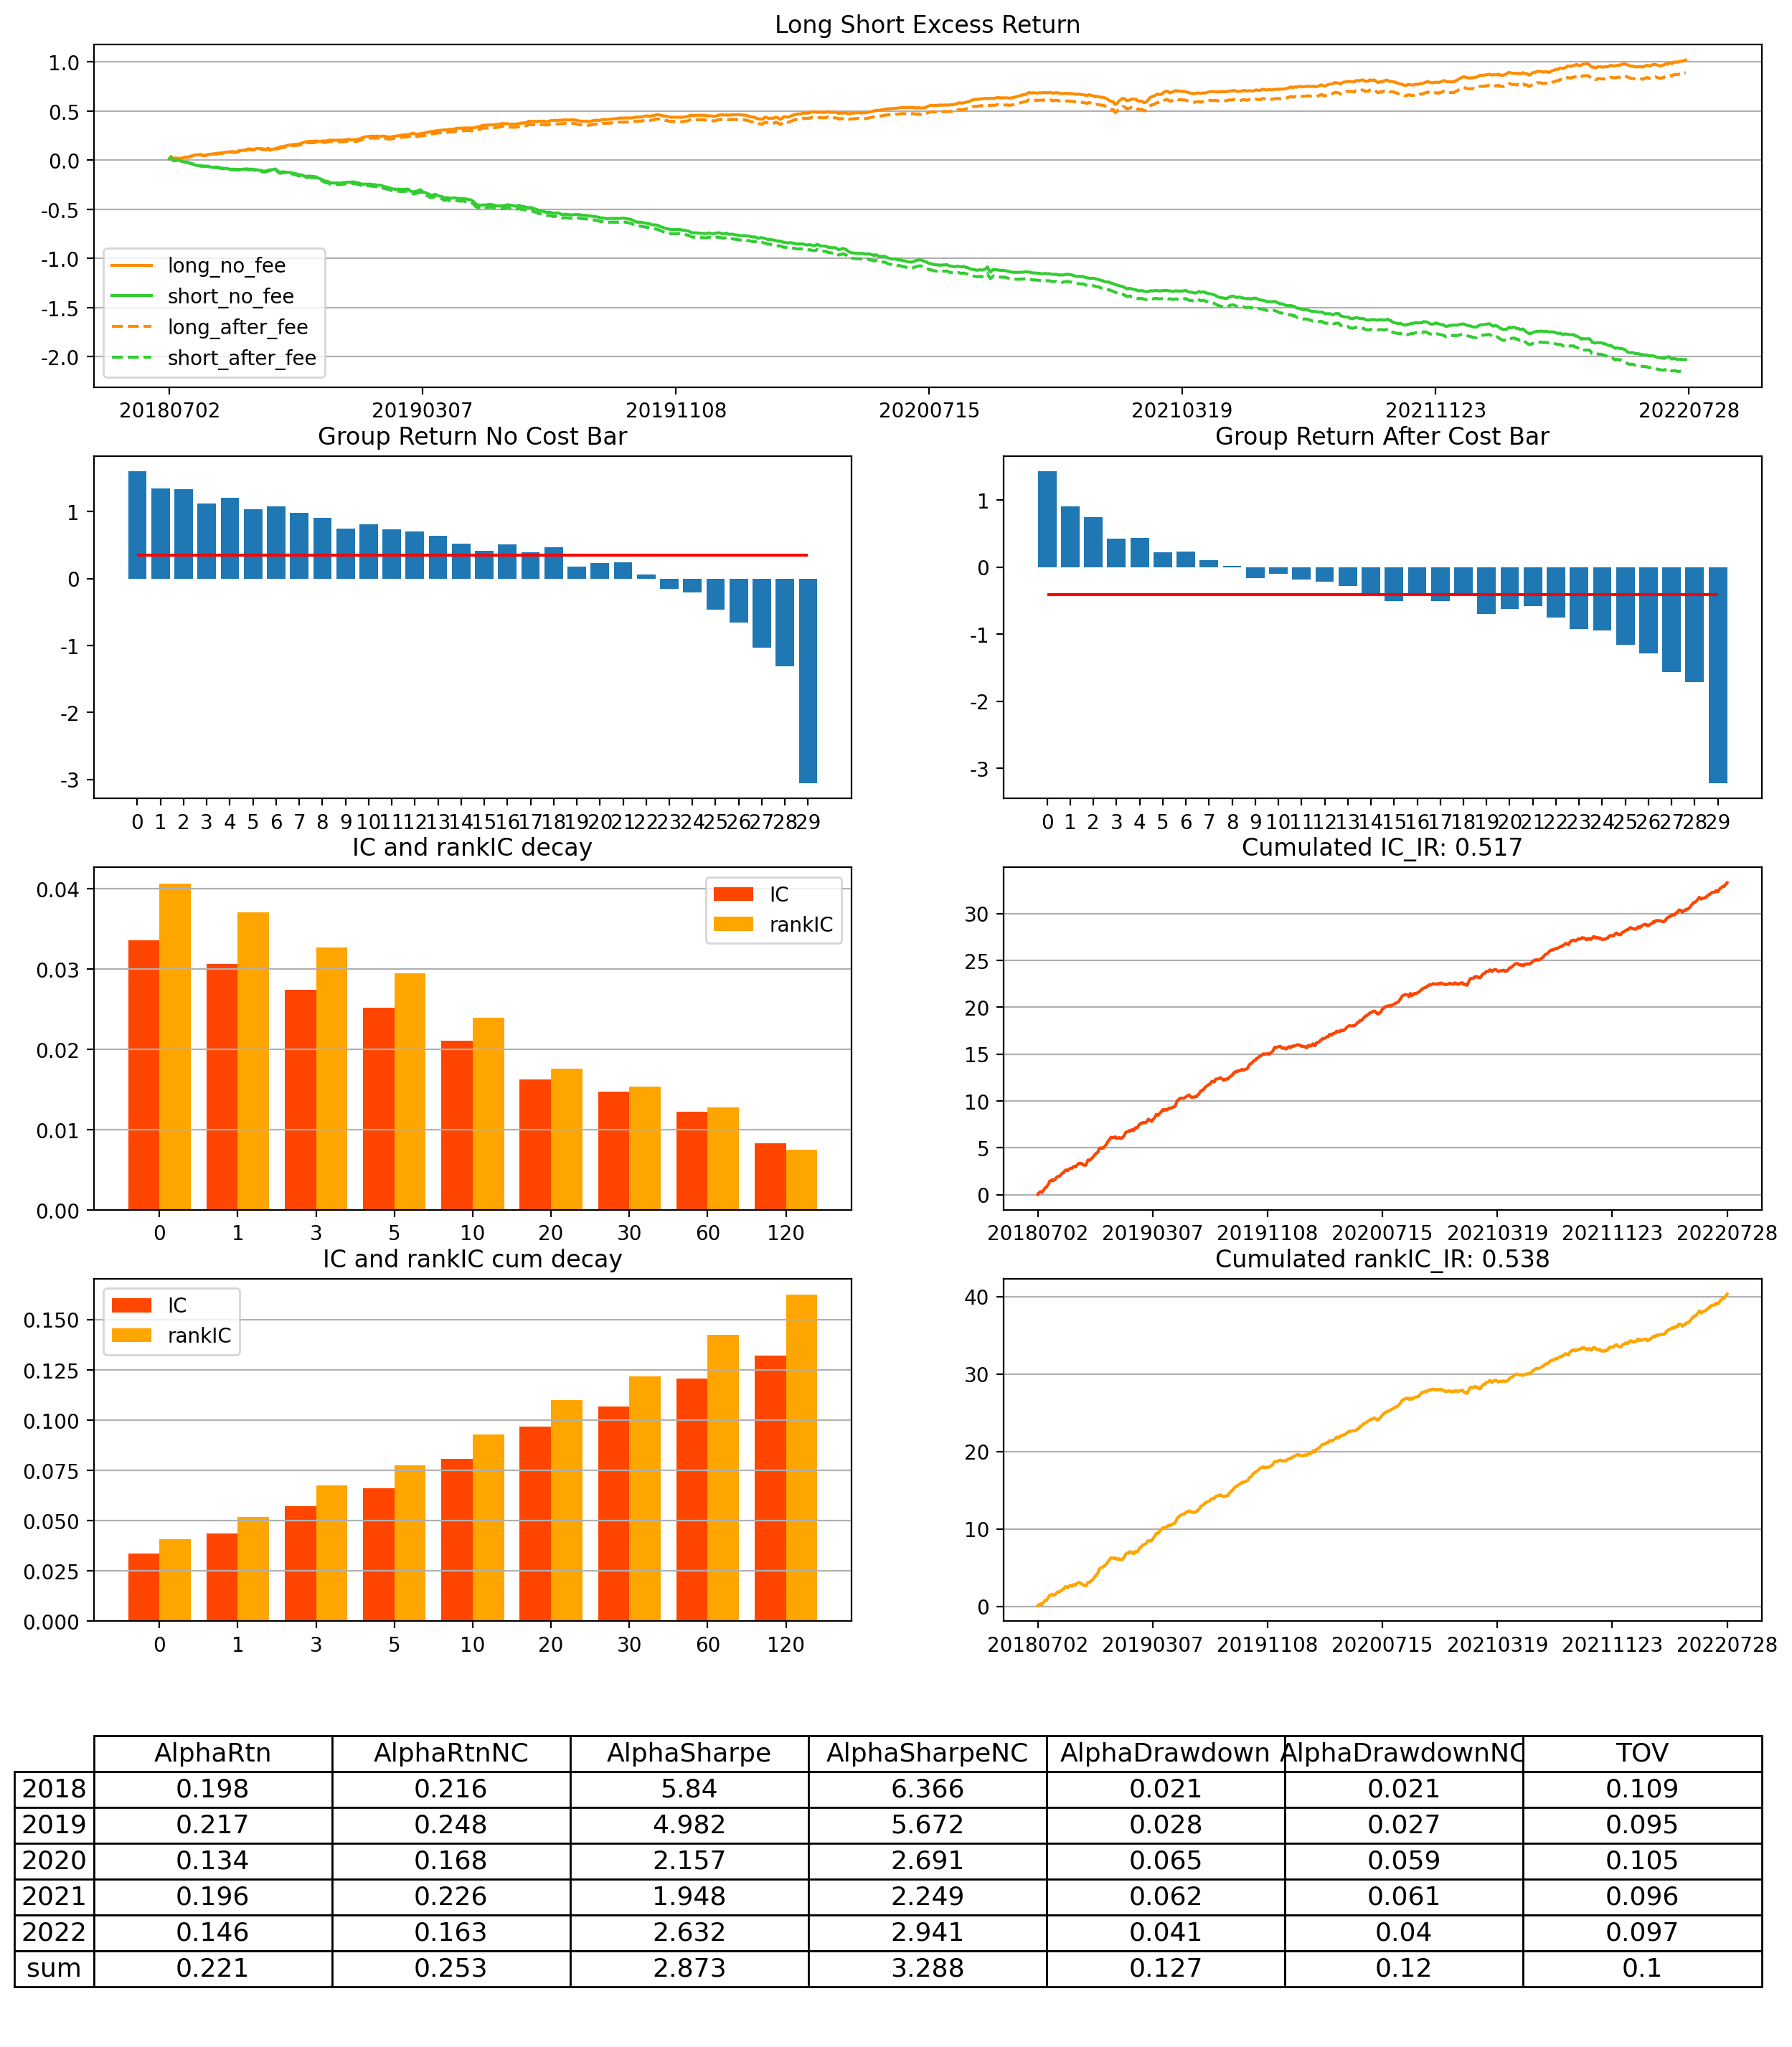

In [173]:
res_temp = bcl.backtest_bycdb(df_temp, cfg);

In [164]:
def calc_long_short(result):
    sr_l_rtn_no_fee = result['long_short']['long_short_cum_pnl']['long_rtn_no_fee']
    sr_l_rtn_after_fee = result['long_short']['long_short_cum_pnl']['long_rtn_after_fee']
    sr_s_rtn_no_fee = result['long_short']['long_short_cum_pnl']['short_rtn_no_fee']
    sr_s_rtn_after_fee = result['long_short']['long_short_cum_pnl']['short_rtn_after_fee']
    
    sr_s_fee = sr_s_rtn_no_fee - sr_s_rtn_after_fee
    sr_s_rtn_after_fee = sr_s_rtn_no_fee + sr_s_fee
    
    plt.figure(figsize=(20, 5))
    sr_l_rtn_no_fee.plot(label='long_no_fee', color='darkorange')
    sr_l_rtn_after_fee.plot(label='long_after_fee', color='darkorange', linestyle='--')
    sr_s_rtn_no_fee.plot(label='short_no_fee', color='limegreen')
    sr_s_rtn_after_fee.plot(label='short_after_fee', color='limegreen', linestyle='--')
    
    sr_ls_no_fee = sr_l_rtn_no_fee - sr_s_rtn_no_fee
    sr_ls_after_fee = sr_l_rtn_after_fee - sr_s_rtn_after_fee
    
    sr_ls_no_fee.plot(label='long_short_no_fee', color='b')
    sr_ls_after_fee.plot(label='long_short_after_fee', color='b', linestyle='--')
    
    plt.grid()
    plt.legend()
    
    return sr_ls_no_fee, sr_ls_after_fee

def max_drawdown_series(cumulative_returns):
    max_return = cumulative_returns[0]
    max_drawdown_series = []
    for i in range(1, len(cumulative_returns)):
        max_return = max(max_return, cumulative_returns[i])
        drawdown = max_return - cumulative_returns[i]
        max_drawdown_series.append(drawdown)
    return max_drawdown_series

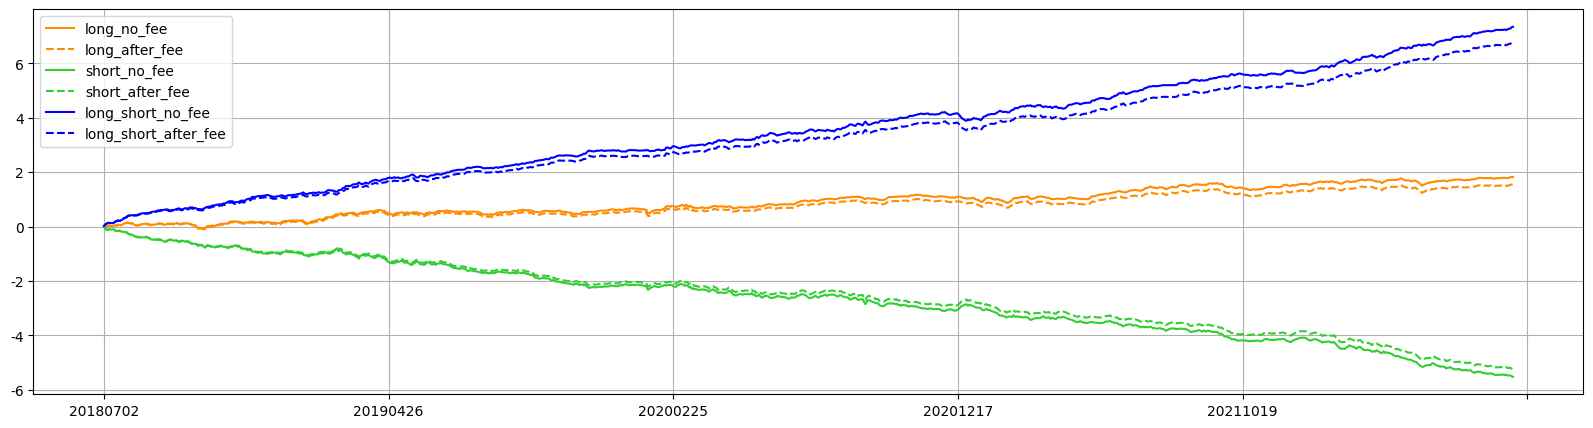

In [165]:
temp = calc_long_short(res_temp);

In [166]:
idx = res['long_short']['long_short_cum_pnl']['short_rtn_no_fee'].index[1:]

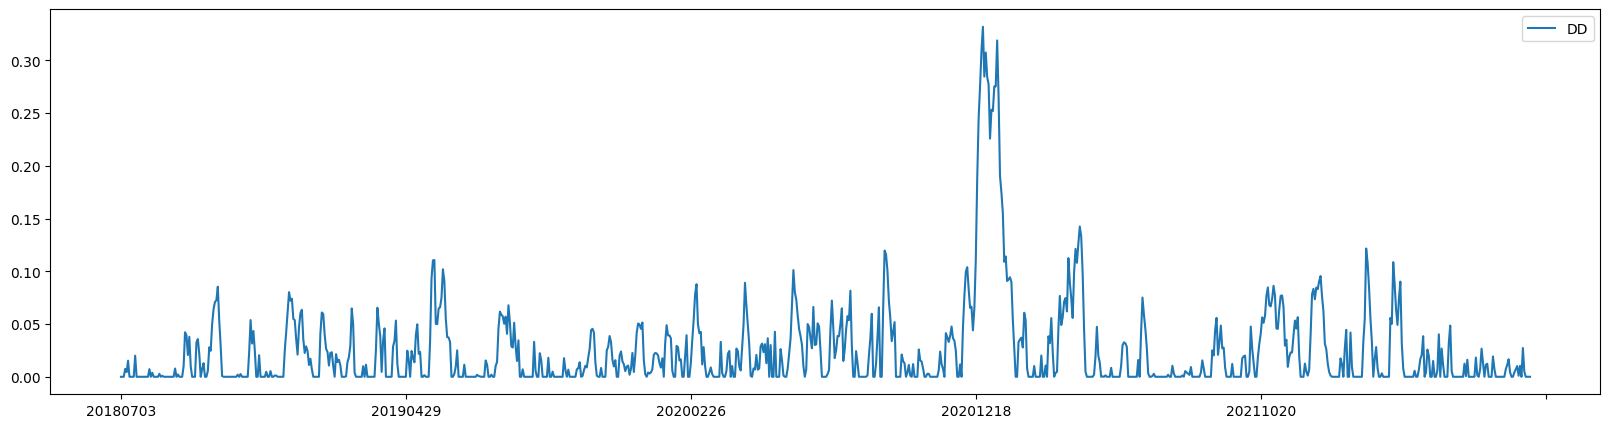

In [167]:
pd.DataFrame(index=idx, columns = ['DD'], data=max_drawdown_series(temp[1])).plot(figsize=(20, 5));

In [168]:
temp[1].diff().mean()/temp[1].diff().std()*np.sqrt(252)

4.8274548366456616

In [169]:
temp[1].diff().mean() * 252

1.7217768828360471

In [1004]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [1040]:
data_temp = ds.get_eod_feature(fields=['eod_v2', 'eod_mixed', 'eod_hf_combo1'],
                               where='/home/zyding/Test',
                               dates=[])

In [172]:
df_temp = ds.get_eod_feature(
    fields='eod_hf_combo1',
    where='/home/zyding/Test',
    dates=[])[0].to_dataframe().dropna(how='all').dropna(1, how='all')

In [162]:
df_temp = df_temp[tickers_zz800_eod.isnull()]

In [1340]:
save_factor('eod_pair_mixed_avail', df_temp, '/home/zyding/Test')

<AxesSubplot:>

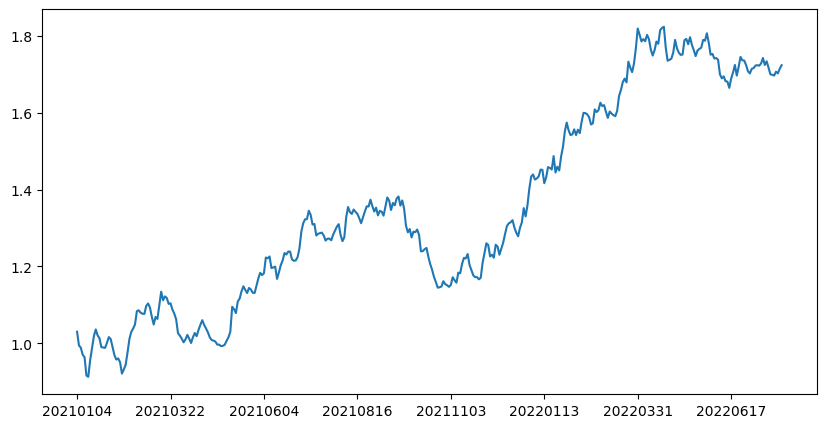

In [170]:
(res_temp['long_short']['long_short_alpha_pnl']['long_rtn_after_fee']['20210101':]+1).cumprod().plot(figsize=(10, 5))

<AxesSubplot:>

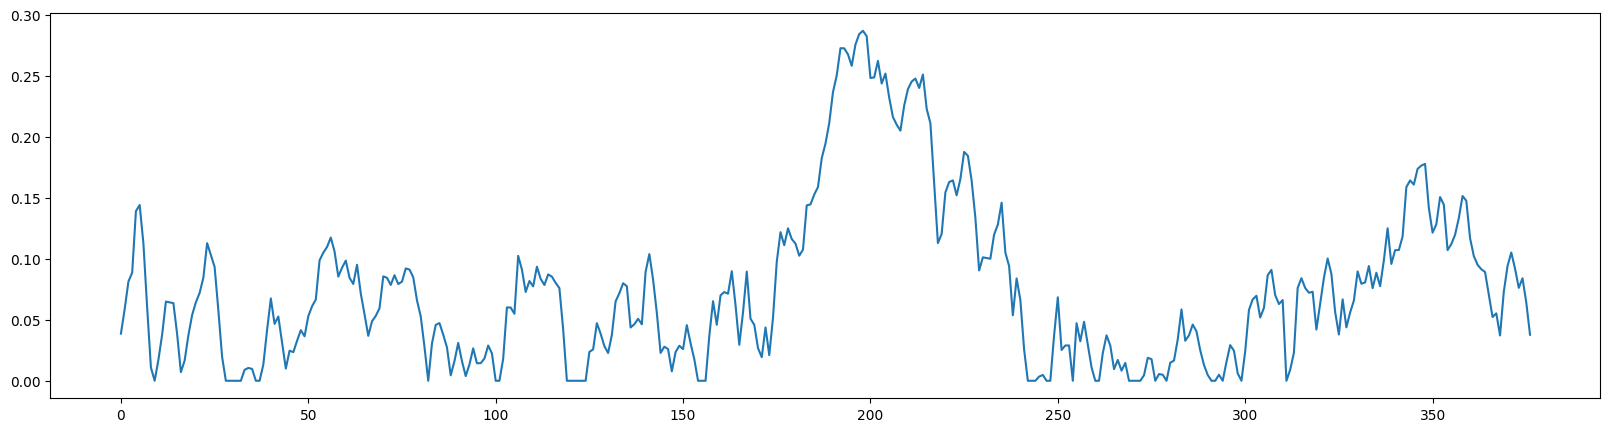

In [128]:
pd.Series(max_drawdown_series((res_temp['long_short']['long_short_alpha_pnl']['long_rtn_after_fee']['20210101':]+1).cumprod())).plot(figsize=(20, 5))